# Test modelling and filtering vs filtering wavelet and modelling

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, sosfiltfilt, correlate, freqs
from scipy.ndimage import gaussian_filter
from pylops.utils.tapers import taper

from devito import configuration
from examples.seismic import AcquisitionGeometry, Model, Receiver
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

from devitofwi.utils import clear_devito_cache
from devitofwi.preproc.filtering import filter_data, Filter
from devitofwi.waveengine.acoustic import AcousticWave2D

configuration['log-level'] = 'ERROR'
#configuration['log-level'] = 'WARNING'

In [2]:
clear_devito_cache()

## Parameters 

In [3]:
# Model and aquisition parameters
par = {'nx':601,   'dx':15,    'ox':0,
       'nz':221,   'dz':15,    'oz':0,
       'ns':1,     'ds':300,   'os':4000,  'sz':0,
       'nr':300,   'dr':30,    'or':0,     'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':15,
       'niters': 5
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin' # true model 

## Acquisition set-up

In [4]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1] * 1e3 # in ms

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

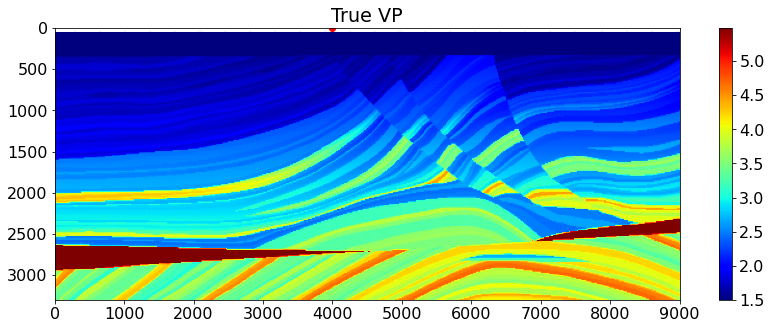

In [5]:
# function to get water layer mask
def mask(m, value):
    """
    Return a mask for the model (m) using the (value)
    """
    msk = m > value
    msk = msk.astype(int)
    return msk

# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T
msk = mask(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

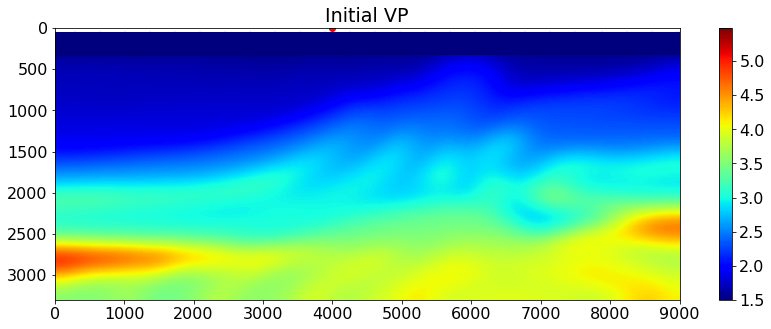

In [6]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

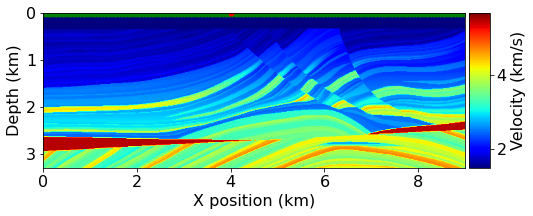

In [7]:
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vp=vp_true * 1e3, 
                      src_type='Ricker', f0=par['freq'],
                      space_order=space_order, nbl=nbl)

plot_velocity(amod.model, amod.geometry.src_positions, 
              amod.geometry.rec_positions)

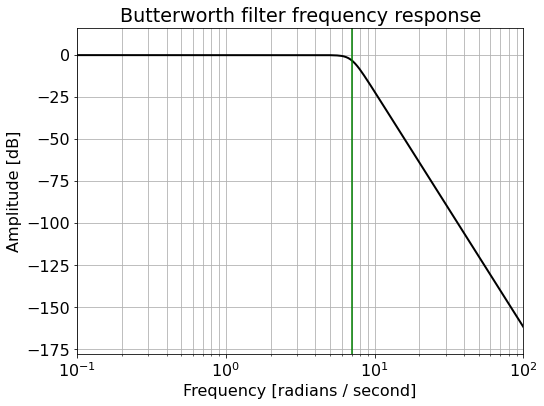

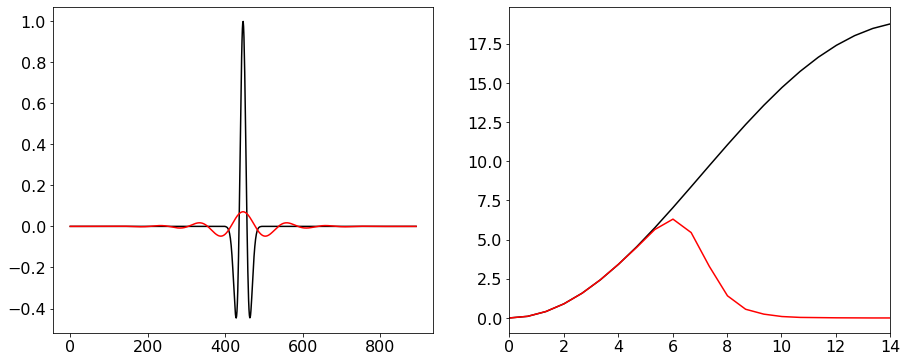

In [8]:
# Extract wavelet and pad it
wav = np.array(amod.geometry.src.data[:]).squeeze()
wav = wav[:2*np.argmax(wav)+1]
wav = np.pad(wav, (400, 400))

# Low-pass filter wavelet
nfilt = 7
fmax = 7
ntap = 200
b, a, sos, wavfilt = filter_data(nfilt, None, fmax, amod.geometry.dt * 1e-3, wav.squeeze(), plotflag=True)
wavfilt *= taper(len(wav), ntap, tapertype='cosine')

nfft = 2**10
f = np.fft.rfftfreq(nfft, amod.geometry.dt * 1e-3)
WAV = np.fft.rfft(wav, nfft)
WAVfilt = np.fft.rfft(wavfilt, nfft)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(wav, 'k')
axs[0].plot(wavfilt, 'r')
axs[1].plot(f, np.abs(WAV), 'k')
axs[1].plot(f, np.abs(WAVfilt), 'r')
axs[1].set_xlim(0, fmax*2);

In [9]:
# Model data with original wavelet
amod.wav = np.pad(wav, (0, amod.geometry.src.nt - len(wav)))
dobs = amod._mod_allshots().squeeze()

# Filter data
dobsfilt = sosfiltfilt(sos, dobs.T, axis=-1).T

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# Model data with filtered wavelet
amod.wav = np.pad(wavfilt, (0, amod.geometry.src.nt - len(wavfilt)))
dobswavfilt = amod._mod_allshots().squeeze()

  0%|          | 0/1 [00:00<?, ?it/s]

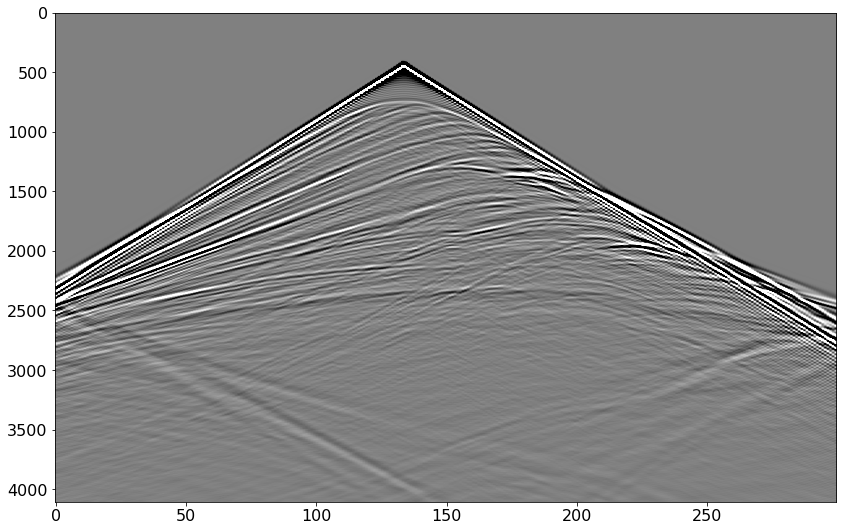

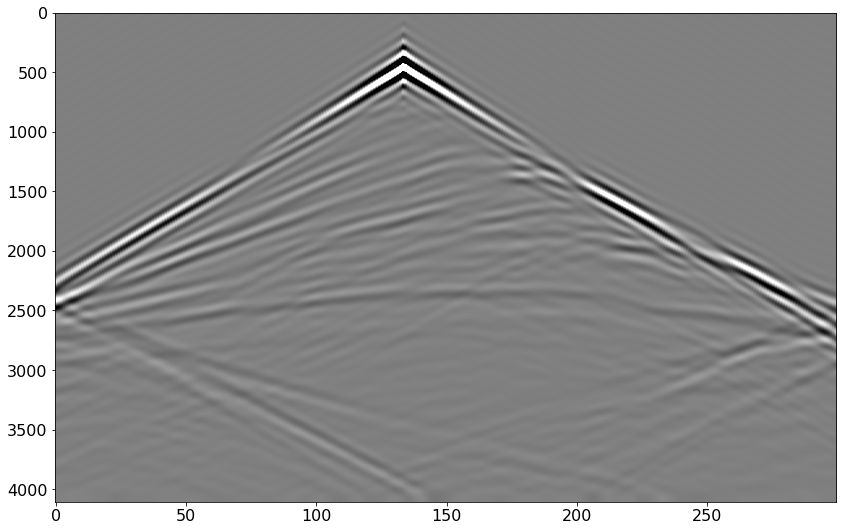

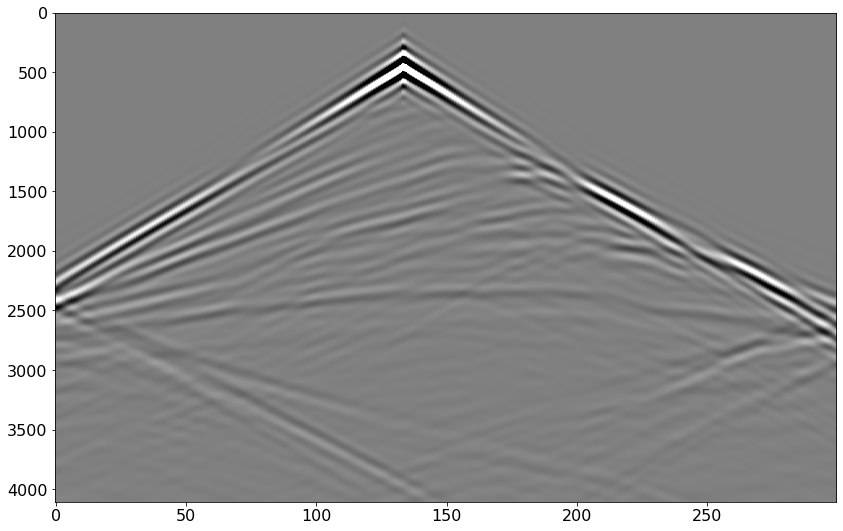

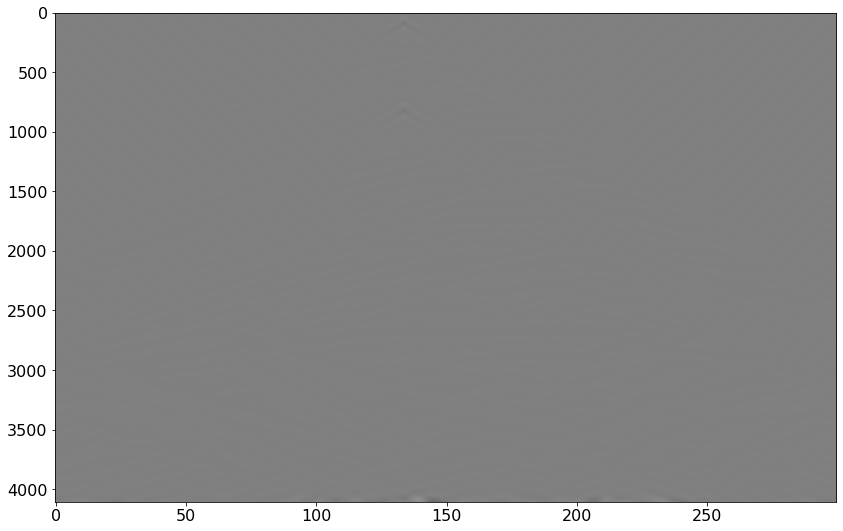

In [11]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobs, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax)

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobsfilt, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax)

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobswavfilt, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax);

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobsfilt-dobswavfilt, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax);

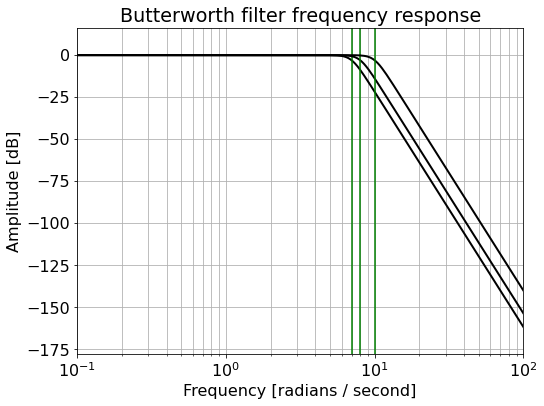

In [12]:
Filt = Filter([7, 8, 10], [7, 7, 7], amod.geometry.dt * 1e-3, plotflag=True)

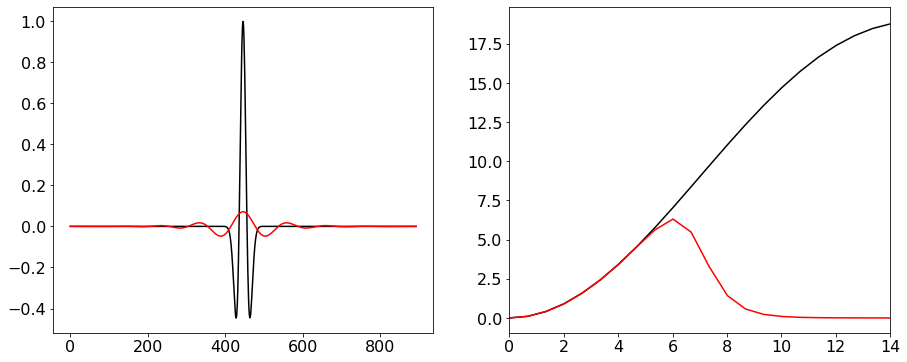

In [13]:
wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=0)

WAV = np.fft.rfft(wav, nfft)
WAVfilt = np.fft.rfft(wavfilt, nfft)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(wav, 'k')
axs[0].plot(wavfilt, 'r')
axs[1].plot(f, np.abs(WAV), 'k')
axs[1].plot(f, np.abs(WAVfilt), 'r')
axs[1].set_xlim(0, fmax*2);

  0%|          | 0/1 [00:00<?, ?it/s]

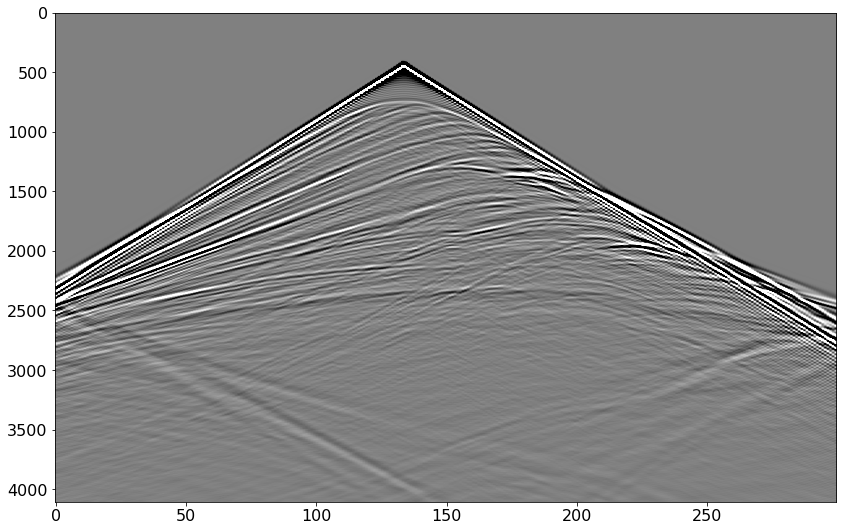

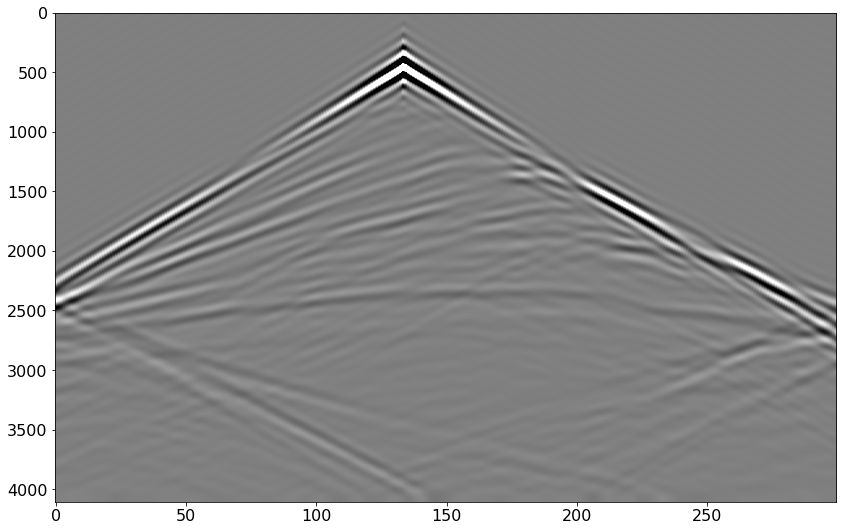

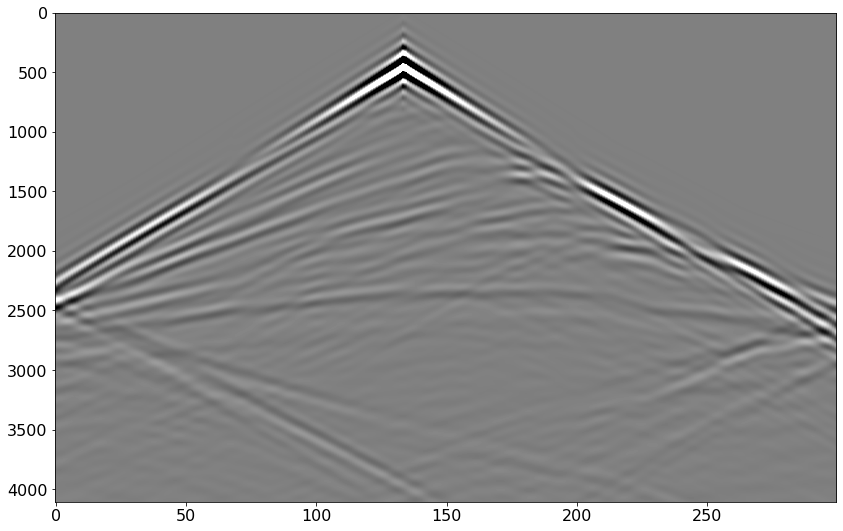

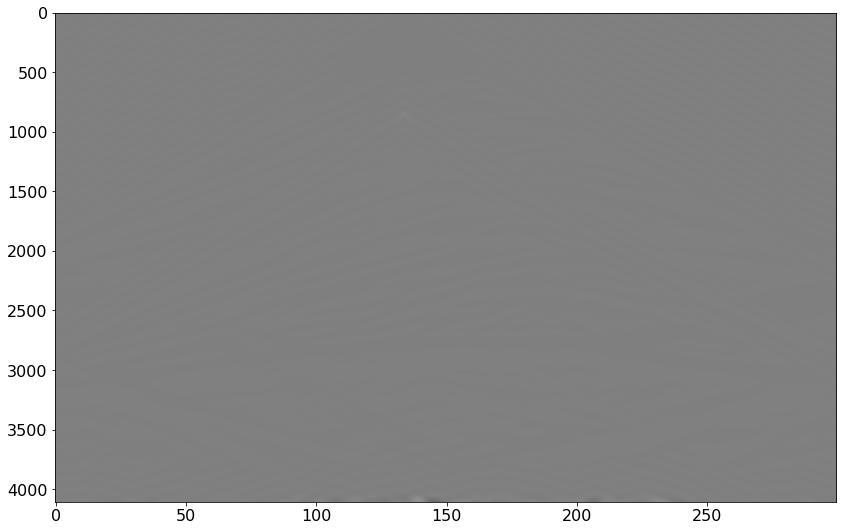

In [14]:
dobsfilt = Filt.apply_filter(dobs.T, ifilt=0).T
amod.wav = np.pad(wavfilt, (0, amod.geometry.src.nt - len(wavfilt)))
dobswavfilt = amod._mod_allshots().squeeze()

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobs, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax)

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobsfilt, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax)

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobswavfilt, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax);

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobsfilt-dobswavfilt, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax);